# **Install**

In [2]:
!pip install numpy==1.26.0
!pip install pandas==2.2.1
!pip install seaborn==0.13.2
!pip install matplotlib==3.8.3
!pip install scikit-learn==1.4.1.post1

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/61.1 kB ? eta -:--:--
     ------------ ------------------------- 20.5/61.1 kB 640.0 kB/s eta 0:00:01
     ------------------------- ------------ 41.0/61.1 kB 393.8 kB/s eta 0:00:01
     -------------------------------------- 61.1/61.1 kB 466.4 kB/s eta 0:00:00
   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/15.5 MB 3.4 MB/s eta 0:00:05
    --------------------------------------- 0.2/15.5 MB 3.0 MB/s eta 0:00:06
    --------------------------------------- 0.4/15.5 MB 2.8 MB/s eta 0:00:06
   - -------------------------------------- 0.5/15.5 MB 3.3 MB/s eta 0:00:05
   - -------------------------------------- 0.7/15.5 MB 3.4 MB/s eta 0:00:05
   -- ------------------------------------- 0.9/15.5 MB 3.6 MB/s eta 0:00:05
   -- ------------------------------------- 1.1/15.5 MB 3.8 MB/s eta 0:00:04
 

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.5 MB 2.0 MB/s eta 0:00:06
   ---------------------------------------- 0.1/11.5 MB 1.7 MB/s eta 0:00:07
    --------------------------------------- 0.2/11.5 MB 2.0 MB/s eta 0:00:06
   - -------------------------------------- 0.3/11.5 MB 1.9 MB/s eta 0:00:06
   - -------------------------------------- 0.5/11.5 MB 2.4 MB/s eta 0:00:05
   -- ------------------------------------- 0.6/11.5 MB 2.4 MB/s eta 0:00:05
   -- ------------------------------------- 0.9/11.5 MB 2.9 MB/s eta 0:00:04
   --- ------------------------------------ 1.0/11.5 MB 2.7 MB/s eta 0:00:04
   ---- ----------------------------------- 1.3/11.5 MB 3.2 MB/s eta 0:00:04
   ----- ---------------------------------- 1.5/11.5 MB 3.4 MB/s eta 0:00:03
   ------ --------------------------------- 1.7/11.5 MB 3.6 MB/s eta 0:00:03
   --

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.6 MB 145.2 kB/s eta 0:00:53
   ---------------------------------------- 0.1/7.6 MB 217.9 kB/s eta 0:00:35
   ---------------------------------------- 0.1/7.6 MB 261.4 kB/s eta 0:00:29
   ---------------------------------------- 0.1/7.6 MB 255.1 kB/s eta 0:00:30
   ---------------------------------------- 0.1/7.6 MB 255.1 kB/s eta 0:00:30
    --------------------------------------- 0.1/7.6 MB 227.0 kB/s eta 0:00:34
    --------------------------------------- 0.1/7.6 MB 227.0 kB/s eta 0:00:34
    ---------------------------

# **Import**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

# **Used Functions**

In [2]:
#Write here your function with comments


# Outlier detection function using IQR method
def detect_outliers_iqr(df):
    outliers_indices = {}  
    for col in df.columns:  
        Q1 = df[col].quantile(0.25)  
        Q3 = df[col].quantile(0.75)  
        IQR = Q3 - Q1  
        lower_bound = Q1 - 1.5 * IQR  
        upper_bound = Q3 + 1.5 * IQR  
        outliers_indices[col] = df.index[(df[col] < lower_bound) | (df[col] > upper_bound)].tolist()
    return outliers_indices  


# **Data**

### **Data Read**

In [3]:
data=pd.read_csv("ApartmentRentPrediction.csv")

### **Data Header**

In [4]:
data.head(5)

,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,...,price_display,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,5508832632,housing/rent/apartment,"Two BR - $1,194/mo - Apartment - come and see ...","Come experience. in Cary, NC offering recently...","Clubhouse,Fireplace,Gym,Patio/Deck,Playground,...",2.5,2.0,USD,No,Thumbnail,...,"$1,194",Monthly,800,NaN,Cary,NC,35.7585,-78.7783,RentDigs.com,1568755960
1,5664576849,housing/rent/apartment,One BR 640 West Wilson Street,This unit is located at 640 West Wilson Street...,"Cable or Satellite,Dishwasher,Elevator,Garbage...",1.0,1.0,USD,No,Thumbnail,...,"$1,370",Monthly,795,640 West Wilson St,Madison,WI,43.0724,-89.4003,RentLingo,1577015508
2,5668619365,housing/rent/apartment,One BR 2777 Sw Archer Rd,"This unit is located at 2777 Sw Archer Rd, Gai...","Basketball,Cable or Satellite,Dishwasher,Inter...",1.0,1.0,USD,No,Thumbnail,...,"$1,009",Monthly,560,2777 SW Archer Road,Gainesville,FL,29.6533,-82.3656,RentLingo,1577358921
3,5668632604,housing/rent/apartment,One BR 534-542 Park Avenue,"This unit is located at 534-542 Park Avenue, O...",NaN,1.0,1.0,USD,No,Thumbnail,...,$695,Monthly,600,534-542 Park Ave,Omaha,NE,41.2562,-96.0404,RentLingo,1577359849
4,5668637441,housing/rent/apartment,Three BR 2216 S Palm Grove Ave,"This unit is located at 2216 S Palm Grove Ave,...",NaN,3.0,3.0,USD,No,Thumbnail,...,"$3,695",Monthly,1600,2216 S Palm Grove Avenue,Los Angeles,CA,34.0372,-118.2972,RentLingo,1577360159


### **Data Describe**

In [5]:
data.describe()

,id,bathrooms,bedrooms,price,square_feet,latitude,longitude,time
count,9.000000e+03,8970.000000,8993.000000,9000.000000,9000.000000,8993.00000,8993.000000,9.000000e+03
mean,5.623668e+09,1.380769,1.744023,1487.286222,947.138667,37.67689,-94.778612,1.574906e+09
std,7.007402e+07,0.616171,0.942446,1088.561190,668.806214,5.51527,15.769232,3.755142e+06
min,5.508654e+09,1.000000,0.000000,200.000000,106.000000,21.31550,-158.022100,1.568744e+09
25%,5.509250e+09,1.000000,1.000000,950.000000,650.000000,33.66200,-101.858700,1.568781e+09
50%,5.668610e+09,1.000000,2.000000,1275.000000,802.000000,38.75550,-93.707700,1.577358e+09
75%,5.668626e+09,2.000000,2.000000,1695.000000,1100.000000,41.34980,-82.446800,1.577359e+09
max,5.668663e+09,8.500000,9.000000,52500.000000,40000.000000,61.59400,-70.191600,1.577362e+09


### **Data Info**

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             9000 non-null   int64  
 1   category       9000 non-null   object 
 2   title          9000 non-null   object 
 3   body           9000 non-null   object 
 4   amenities      5815 non-null   object 
 5   bathrooms      8970 non-null   float64
 6   bedrooms       8993 non-null   float64
 7   currency       9000 non-null   object 
 8   fee            9000 non-null   object 
 9   has_photo      9000 non-null   object 
 10  pets_allowed   5249 non-null   object 
 11  price          9000 non-null   int64  
 12  price_display  9000 non-null   object 
 13  price_type     9000 non-null   object 
 14  square_feet    9000 non-null   int64  
 15  address        6029 non-null   object 
 16  cityname       8934 non-null   object 
 17  state          8934 non-null   object 
 18  latitude

### **Data Nulls**

In [7]:
data.isna().sum()

id                  0
category            0
title               0
body                0
amenities        3185
bathrooms          30
bedrooms            7
currency            0
fee                 0
has_photo           0
pets_allowed     3751
price               0
price_display       0
price_type          0
square_feet         0
address          2971
cityname           66
state              66
latitude            7
longitude           7
source              0
time                0
dtype: int64

## **Phase One**

### **Wrong Values**

In [8]:
wrong_values = data.copy() 

In [9]:
wrong_values["has_photo"].value_counts()

has_photo
Thumbnail    8025
Yes           816
No            159
Name: count, dtype: int64

In [10]:
wrong_values['bedrooms']=wrong_values['bedrooms'].apply(np.floor).astype(float)
wrong_values['bathrooms'] = wrong_values['bathrooms'].apply(np.floor).astype(float)
wrong_values.loc[wrong_values["has_photo"] == "Thumbnail", "has_photo"] = "Yes"

### **Datatype Check**

In [11]:
#Convert Bathrooms to int
#Convert Bedrooms to int
#Convert Has_Photo to category
#Convert State to int
#Convert Source to int
#Convert Time to int
#Convert Source to int

In [12]:
DataCheck = wrong_values.copy()

In [13]:
DataCheck["has_photo"] = DataCheck["has_photo"].astype("category")

In [14]:
DataCheck["state"] = DataCheck["state"].astype("category")

In [15]:
DataCheck["source"] = DataCheck["source"].astype("category")

In [16]:
DataCheck["time"] = pd.to_datetime(DataCheck["time"])

In [17]:
DataCheck["cityname"]=DataCheck["cityname"].astype("category")

In [18]:
DataCheck.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             9000 non-null   int64         
 1   category       9000 non-null   object        
 2   title          9000 non-null   object        
 3   body           9000 non-null   object        
 4   amenities      5815 non-null   object        
 5   bathrooms      8970 non-null   float64       
 6   bedrooms       8993 non-null   float64       
 7   currency       9000 non-null   object        
 8   fee            9000 non-null   object        
 9   has_photo      9000 non-null   category      
 10  pets_allowed   5249 non-null   object        
 11  price          9000 non-null   int64         
 12  price_display  9000 non-null   object        
 13  price_type     9000 non-null   object        
 14  square_feet    9000 non-null   int64         
 15  address        6029 n

### **Needed Columns**

In [19]:
#Remove ID Column
#Remove Category Column
#Remove Title Column
#Remove Body Column
#Remove Currency Column
#Remove Fee Column
#Remove Price Display Column
#Remove Price Type Column
#Remove Time Column

In [20]:
#Remove ID Column
#Not useful in data
DataCheck = DataCheck.drop('id', axis=1)

In [21]:
#Remove Category Column
#Not useful in data due to 8997 "housing/rent/apartment" repetation
print(DataCheck['category'].value_counts())
DataCheck = DataCheck.drop('category', axis=1)

category
housing/rent/apartment     8997
housing/rent/short_term       2
housing/rent/home             1
Name: count, dtype: int64


In [22]:
#Remove Title Column
#Not useful in data
DataCheck = DataCheck.drop('title', axis=1)

In [23]:
#Remove Body Column
#Not useful in data
DataCheck = DataCheck.drop('body', axis=1)

In [24]:
#Remove address Column
#inconsistent data that have 3000 null rows
DataCheck = DataCheck.drop('address', axis=1)

In [25]:
#Remove Currency Column
#Not useful in data due to no unique values
print(DataCheck['currency'].value_counts())
DataCheck = DataCheck.drop('currency', axis=1)

currency
USD    9000
Name: count, dtype: int64


In [26]:
#Remove Fee Column
#Not useful in data due to no unique values
print(DataCheck['fee'].value_counts())
DataCheck = DataCheck.drop('fee', axis=1)

fee
No    9000
Name: count, dtype: int64


In [27]:
#Remove Price Display Column
#Not useful in data due to repition of price column
DataCheck['price_display'] = pd.to_numeric(DataCheck['price_display'].str.replace('$', '').str.replace(',', '').str.replace('Weekly', '').str.replace('Monthly|', ''))
comparison = DataCheck['price_display'] == DataCheck['price']
print(comparison.value_counts())
DataCheck = DataCheck.drop('price_display', axis=1)

True    9000
Name: count, dtype: int64


In [28]:
#Remove Price Type Column
#Not useful in data due to 8998 "Monthly" repetation
print(DataCheck['price_type'].value_counts())
DataCheck = DataCheck.drop('price_type', axis=1)

price_type
Monthly           8998
Weekly               1
Monthly|Weekly       1
Name: count, dtype: int64


In [29]:
#Remove Time Column
#Not useful in data due to 9000 "1970-01-01" date repetation
DataCheck = DataCheck.drop('time', axis=1)

In [30]:
#Check Data After Uneeded Columns Removal
DataCheck.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   amenities     5815 non-null   object  
 1   bathrooms     8970 non-null   float64 
 2   bedrooms      8993 non-null   float64 
 3   has_photo     9000 non-null   category
 4   pets_allowed  5249 non-null   object  
 5   price         9000 non-null   int64   
 6   square_feet   9000 non-null   int64   
 7   cityname      8934 non-null   category
 8   state         8934 non-null   category
 9   latitude      8993 non-null   float64 
 10  longitude     8993 non-null   float64 
 11  source        9000 non-null   category
dtypes: category(4), float64(4), int64(2), object(2)
memory usage: 653.5+ KB


### **Fill Nulls**

In [31]:
# Data to work on
null_data=DataCheck.copy()

In [32]:
# Removing the null rows of cityname and latitude
null_data=null_data.dropna(axis=0,subset=["cityname","latitude","bathrooms","bedrooms"])

In [33]:
null_data["bathrooms"]=null_data["bathrooms"].astype("int")

In [34]:
null_data["bedrooms"]=null_data["bedrooms"].astype("int")

In [35]:
# Filling nulls of pets_allowed coloumn to no
null_data["pets_allowed"]=null_data["pets_allowed"].fillna("No")
null_data["pets_allowed"]=null_data["pets_allowed"].astype("category")
#pets_allowed_fill_data = null_data.dropna(subset =["pets_allowed"],axis =0)
#null_data["pets_allowed"]=null_data["pets_allowed"].fillna(pets_allowed_fill_data["pets_allowed"].mode()[0])
#null_data["pets_allowed"]=null_data["pets_allowed"].astype("category")

In [36]:
#pets_allowed_fill_data

NameError: name 'pets_allowed_fill_data' is not defined

In [37]:
null_data["pets_allowed"].value_counts()

pets_allowed
Cats,Dogs    4651
No           3705
Cats          429
Dogs          113
Name: count, dtype: int64

In [38]:
null_data["amenities"]=null_data["amenities"].fillna(null_data["amenities"].mode()[0])


In [39]:
null_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8898 entries, 0 to 8999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   amenities     8898 non-null   object  
 1   bathrooms     8898 non-null   int32   
 2   bedrooms      8898 non-null   int32   
 3   has_photo     8898 non-null   category
 4   pets_allowed  8898 non-null   category
 5   price         8898 non-null   int64   
 6   square_feet   8898 non-null   int64   
 7   cityname      8898 non-null   category
 8   state         8898 non-null   category
 9   latitude      8898 non-null   float64 
 10  longitude     8898 non-null   float64 
 11  source        8898 non-null   category
dtypes: category(5), float64(2), int32(2), int64(2), object(1)
memory usage: 585.9+ KB


In [40]:
null_data.isna().sum()

amenities       0
bathrooms       0
bedrooms        0
has_photo       0
pets_allowed    0
price           0
square_feet     0
cityname        0
state           0
latitude        0
longitude       0
source          0
dtype: int64

In [41]:
#no_nulls_in_amenities = null_data.dropna(subset =["amenities"],axis =0)
no_nulls_in_amenities = null_data.copy()
#test["amenities"] = test["amenities"].str.split(",")
clone=no_nulls_in_amenities.copy()
no_nulls_in_amenities = no_nulls_in_amenities["amenities"].str.split(",")
no_nulls_in_amenities=no_nulls_in_amenities.reset_index()
#no_nulls_in_amenities["amenities"]=no_nulls_in_amenities["amenities"].fillna("[]")

In [42]:
no_nulls_in_amenities

,index,amenities
0,0,"[Clubhouse, Fireplace, Gym, Patio/Deck, Playgr..."
1,1,"[Cable or Satellite, Dishwasher, Elevator, Gar..."
2,2,"[Basketball, Cable or Satellite, Dishwasher, I..."
3,3,[Parking]
4,4,[Parking]
...,...,...
8893,8995,"[Clubhouse, Gym, Patio/Deck, Pool]"
8894,8996,[Parking]
8895,8997,"[Parking, Storage]"
8896,8998,"[AC, Clubhouse, Dishwasher, Gated, Gym, Intern..."


In [43]:
li=[]
for x in range(len(no_nulls_in_amenities)) :
    li+=no_nulls_in_amenities.iloc[x]["amenities"]

In [44]:
li

['Clubhouse',
 'Fireplace',
 'Gym',
 'Patio/Deck',
 'Playground',
 'Pool',
 'Cable or Satellite',
 'Dishwasher',
 'Elevator',
 'Garbage Disposal',
 'Internet Access',
 'Parking',
 'Patio/Deck',
 'Refrigerator',
 'Storage',
 'Basketball',
 'Cable or Satellite',
 'Dishwasher',
 'Internet Access',
 'Patio/Deck',
 'Refrigerator',
 'Tennis',
 'Parking',
 'Parking',
 'Parking',
 'Gym',
 'Pool',
 'Parking',
 'Parking',
 'Cable or Satellite',
 'Dishwasher',
 'Elevator',
 'Internet Access',
 'Parking',
 'Patio/Deck',
 'Playground',
 'Refrigerator',
 'Storage',
 'Wood Floors',
 'Dishwasher',
 'Parking',
 'Pool',
 'Refrigerator',
 'Gated',
 'Pool',
 'TV',
 'Dishwasher',
 'Internet Access',
 'Parking',
 'Pool',
 'Refrigerator',
 'AC',
 'Clubhouse',
 'Parking',
 'Playground',
 'Pool',
 'Parking',
 'Dishwasher',
 'Parking',
 'Patio/Deck',
 'Refrigerator',
 'Parking',
 'Parking',
 'Patio/Deck',
 'Pool',
 'Tennis',
 'Parking',
 'Refrigerator',
 'Parking',
 'Parking',
 'Parking',
 'Parking',
 'Parking'

In [45]:
li=set(li)

In [46]:
li

{'AC',
 'Alarm',
 'Basketball',
 'Cable or Satellite',
 'Clubhouse',
 'Dishwasher',
 'Doorman',
 'Elevator',
 'Fireplace',
 'Garbage Disposal',
 'Gated',
 'Golf',
 'Gym',
 'Hot Tub',
 'Internet Access',
 'Luxury',
 'Parking',
 'Patio/Deck',
 'Playground',
 'Pool',
 'Refrigerator',
 'Storage',
 'TV',
 'Tennis',
 'View',
 'Washer Dryer',
 'Wood Floors'}

In [47]:
clone=clone.reset_index()

In [48]:
#Make new columns with boolians
for c in li :
    clone[c]=0
    clone[c]=clone[c].astype("int")

In [49]:
clone

,index,amenities,bathrooms,bedrooms,has_photo,pets_allowed,price,square_feet,cityname,state,...,AC,Tennis,Gym,Alarm,Gated,Patio/Deck,Dishwasher,Parking,Washer Dryer,Cable or Satellite
0,0,"Clubhouse,Fireplace,Gym,Patio/Deck,Playground,...",2,2,Yes,"Cats,Dogs",1194,800,Cary,NC,...,0,0,0,0,0,0,0,0,0,0
1,1,"Cable or Satellite,Dishwasher,Elevator,Garbage...",1,1,Yes,"Cats,Dogs",1370,795,Madison,WI,...,0,0,0,0,0,0,0,0,0,0
2,2,"Basketball,Cable or Satellite,Dishwasher,Inter...",1,1,Yes,"Cats,Dogs",1009,560,Gainesville,FL,...,0,0,0,0,0,0,0,0,0,0
3,3,Parking,1,1,Yes,"Cats,Dogs",695,600,Omaha,NE,...,0,0,0,0,0,0,0,0,0,0
4,4,Parking,3,3,Yes,No,3695,1600,Los Angeles,CA,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8893,8995,"Clubhouse,Gym,Patio/Deck,Pool",1,2,Yes,No,1158,875,New London,CT,...,0,0,0,0,0,0,0,0,0,0
8894,8996,Parking,1,1,Yes,Cats,2035,824,Bellevue,WA,...,0,0,0,0,0,0,0,0,0,0
8895,8997,"Parking,Storage",1,2,Yes,"Cats,Dogs",424,844,Fond Du Lac,WI,...,0,0,0,0,0,0,0,0,0,0
8896,8998,"AC,Clubhouse,Dishwasher,Gated,Gym,Internet Acc...",1,2,Yes,"Cats,Dogs",1417,489,Pico Rivera,CA,...,0,0,0,0,0,0,0,0,0,0


In [50]:
#fill the columns with one
for new in range(len(clone)) :
    for col in li :
        if col in no_nulls_in_amenities.iloc[new]["amenities"] :
            clone.at[new,col]=1
            

In [51]:
clone

,index,amenities,bathrooms,bedrooms,has_photo,pets_allowed,price,square_feet,cityname,state,...,AC,Tennis,Gym,Alarm,Gated,Patio/Deck,Dishwasher,Parking,Washer Dryer,Cable or Satellite
0,0,"Clubhouse,Fireplace,Gym,Patio/Deck,Playground,...",2,2,Yes,"Cats,Dogs",1194,800,Cary,NC,...,0,0,1,0,0,1,0,0,0,0
1,1,"Cable or Satellite,Dishwasher,Elevator,Garbage...",1,1,Yes,"Cats,Dogs",1370,795,Madison,WI,...,0,0,0,0,0,1,1,1,0,1
2,2,"Basketball,Cable or Satellite,Dishwasher,Inter...",1,1,Yes,"Cats,Dogs",1009,560,Gainesville,FL,...,0,1,0,0,0,1,1,0,0,1
3,3,Parking,1,1,Yes,"Cats,Dogs",695,600,Omaha,NE,...,0,0,0,0,0,0,0,1,0,0
4,4,Parking,3,3,Yes,No,3695,1600,Los Angeles,CA,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8893,8995,"Clubhouse,Gym,Patio/Deck,Pool",1,2,Yes,No,1158,875,New London,CT,...,0,0,1,0,0,1,0,0,0,0
8894,8996,Parking,1,1,Yes,Cats,2035,824,Bellevue,WA,...,0,0,0,0,0,0,0,1,0,0
8895,8997,"Parking,Storage",1,2,Yes,"Cats,Dogs",424,844,Fond Du Lac,WI,...,0,0,0,0,0,0,0,1,0,0
8896,8998,"AC,Clubhouse,Dishwasher,Gated,Gym,Internet Acc...",1,2,Yes,"Cats,Dogs",1417,489,Pico Rivera,CA,...,1,0,1,0,1,1,1,1,0,0


In [52]:
clone=clone.drop("amenities",axis=1)
clone["cityname"]=clone["cityname"].astype("category")

In [53]:
clone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8898 entries, 0 to 8897
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   index               8898 non-null   int64   
 1   bathrooms           8898 non-null   int32   
 2   bedrooms            8898 non-null   int32   
 3   has_photo           8898 non-null   category
 4   pets_allowed        8898 non-null   category
 5   price               8898 non-null   int64   
 6   square_feet         8898 non-null   int64   
 7   cityname            8898 non-null   category
 8   state               8898 non-null   category
 9   latitude            8898 non-null   float64 
 10  longitude           8898 non-null   float64 
 11  source              8898 non-null   category
 12  Hot Tub             8898 non-null   int32   
 13  Internet Access     8898 non-null   int32   
 14  View                8898 non-null   int32   
 15  Elevator            8898 non-null   in

In [54]:
no_null_data=clone.copy()

In [55]:
no_null_data["sum_of_items"]=0

In [56]:
for index in range(len(no_null_data)):
    sum_of_items = 0  # Initialize sum_of_items for each row
    for item in li:
        sum_of_items += no_null_data.loc[index, item]  # Add the value of each item to the sum
    no_null_data.loc[index, "sum_of_items"] = sum_of_items  # Assign the sum to the "sum_of_items" column


In [57]:
no_null_data

,index,bathrooms,bedrooms,has_photo,pets_allowed,price,square_feet,cityname,state,latitude,...,Tennis,Gym,Alarm,Gated,Patio/Deck,Dishwasher,Parking,Washer Dryer,Cable or Satellite,sum_of_items
0,0,2,2,Yes,"Cats,Dogs",1194,800,Cary,NC,35.7585,...,0,1,0,0,1,0,0,0,0,6
1,1,1,1,Yes,"Cats,Dogs",1370,795,Madison,WI,43.0724,...,0,0,0,0,1,1,1,0,1,9
2,2,1,1,Yes,"Cats,Dogs",1009,560,Gainesville,FL,29.6533,...,1,0,0,0,1,1,0,0,1,7
3,3,1,1,Yes,"Cats,Dogs",695,600,Omaha,NE,41.2562,...,0,0,0,0,0,0,1,0,0,1
4,4,3,3,Yes,No,3695,1600,Los Angeles,CA,34.0372,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8893,8995,1,2,Yes,No,1158,875,New London,CT,41.3498,...,0,1,0,0,1,0,0,0,0,4
8894,8996,1,1,Yes,Cats,2035,824,Bellevue,WA,47.5988,...,0,0,0,0,0,0,1,0,0,1
8895,8997,1,2,Yes,"Cats,Dogs",424,844,Fond Du Lac,WI,43.7815,...,0,0,0,0,0,0,1,0,0,2
8896,8998,1,2,Yes,"Cats,Dogs",1417,489,Pico Rivera,CA,33.9883,...,0,1,0,1,1,1,1,0,0,11


In [58]:
no_null_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8898 entries, 0 to 8897
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   index               8898 non-null   int64   
 1   bathrooms           8898 non-null   int32   
 2   bedrooms            8898 non-null   int32   
 3   has_photo           8898 non-null   category
 4   pets_allowed        8898 non-null   category
 5   price               8898 non-null   int64   
 6   square_feet         8898 non-null   int64   
 7   cityname            8898 non-null   category
 8   state               8898 non-null   category
 9   latitude            8898 non-null   float64 
 10  longitude           8898 non-null   float64 
 11  source              8898 non-null   category
 12  Hot Tub             8898 non-null   int32   
 13  Internet Access     8898 non-null   int32   
 14  View                8898 non-null   int32   
 15  Elevator            8898 non-null   in

In [59]:
no_null_data.isna().sum()

index                 0
bathrooms             0
bedrooms              0
has_photo             0
pets_allowed          0
price                 0
square_feet           0
cityname              0
state                 0
latitude              0
longitude             0
source                0
Hot Tub               0
Internet Access       0
View                  0
Elevator              0
Basketball            0
Golf                  0
Fireplace             0
Luxury                0
TV                    0
Doorman               0
Refrigerator          0
Clubhouse             0
Storage               0
Garbage Disposal      0
Wood Floors           0
Playground            0
Pool                  0
AC                    0
Tennis                0
Gym                   0
Alarm                 0
Gated                 0
Patio/Deck            0
Dishwasher            0
Parking               0
Washer Dryer          0
Cable or Satellite    0
sum_of_items          0
dtype: int64

In [60]:
phaseOne_data=no_null_data.copy()

## **Phase Two**

### **Outliers**

In [61]:
numcoll=["bathrooms","square_feet"]

In [62]:
numcoll

['bathrooms', 'square_feet']

In [63]:
outliersdata_1=phaseOne_data.copy()
outliersdata=outliersdata_1[numcoll]

<Axes: >

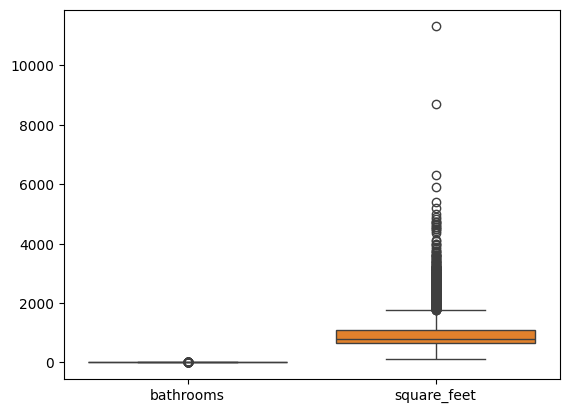

In [64]:
sns.boxplot(outliersdata)

In [65]:
theoutlierindex =detect_outliers_iqr(outliersdata)

In [66]:
theoutlierindex
for key in theoutlierindex.keys() :
    print(f"{key} the len = {len(theoutlierindex[key])}")

bathrooms the len = 63
square_feet the len = 566


In [67]:
Q3 = outliersdata["square_feet"].quantile(0.75)
Q1 = outliersdata["square_feet"].quantile(0.25)

In [68]:
outliersdata.loc[outliersdata["square_feet"] > Q3, "square_feet"] =  Q3
outliersdata.loc[outliersdata["square_feet"] < Q1, "square_feet"] =  Q1

<Axes: >

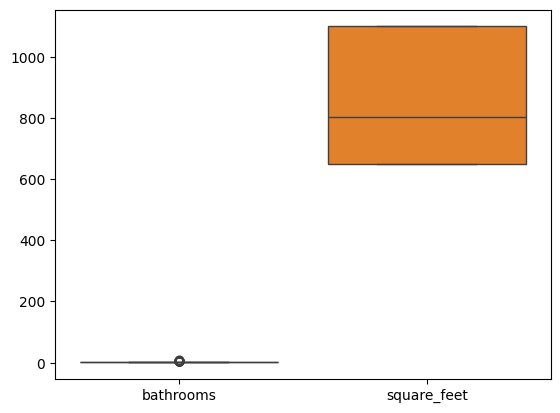

In [69]:
sns.boxplot(outliersdata)

In [70]:
outliersdata_1=outliersdata_1.drop(theoutlierindex['bathrooms'])

<Axes: >

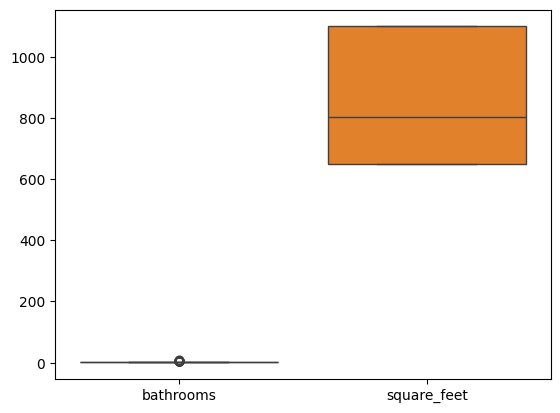

In [71]:
sns.boxplot(outliersdata)

In [72]:
outliersdata_1[numcoll]=outliersdata[numcoll]

In [73]:
outliersdata_1.isna().sum()

index                 0
bathrooms             0
bedrooms              0
has_photo             0
pets_allowed          0
price                 0
square_feet           0
cityname              0
state                 0
latitude              0
longitude             0
source                0
Hot Tub               0
Internet Access       0
View                  0
Elevator              0
Basketball            0
Golf                  0
Fireplace             0
Luxury                0
TV                    0
Doorman               0
Refrigerator          0
Clubhouse             0
Storage               0
Garbage Disposal      0
Wood Floors           0
Playground            0
Pool                  0
AC                    0
Tennis                0
Gym                   0
Alarm                 0
Gated                 0
Patio/Deck            0
Dishwasher            0
Parking               0
Washer Dryer          0
Cable or Satellite    0
sum_of_items          0
dtype: int64

### **Encoding**

In [74]:
encodingdata=outliersdata_1.copy()

In [75]:
for col in encodingdata.columns :
    if encodingdata[col].dtype == "category" :
        encodingdata[col]=encodingdata[col].cat.codes
    

In [76]:
encodingdata.head(10)

,index,bathrooms,bedrooms,has_photo,pets_allowed,price,square_feet,cityname,state,latitude,...,Tennis,Gym,Alarm,Gated,Patio/Deck,Dishwasher,Parking,Washer Dryer,Cable or Satellite,sum_of_items
0,0,2,2,1,1,1194,800,221,26,35.7585,...,0,1,0,0,1,0,0,0,0,6
1,1,1,1,1,1,1370,795,763,47,43.0724,...,0,0,0,0,1,1,1,0,1,9
2,2,1,1,1,1,1009,650,481,9,29.6533,...,1,0,0,0,1,1,0,0,1,7
3,3,1,1,1,1,695,650,982,28,41.2562,...,0,0,0,0,0,0,1,0,0,1
4,4,3,3,1,3,3695,1100,747,4,34.0372,...,0,0,0,0,0,0,1,0,0,1
5,5,2,3,1,3,1750,1100,77,18,30.4415,...,0,0,0,0,0,0,1,0,0,1
6,6,1,2,1,3,2470,1079,759,46,47.8616,...,0,1,0,0,0,0,0,0,0,2
7,7,2,3,1,1,1250,1100,1227,35,35.3537,...,0,0,0,0,0,0,1,0,0,1
8,8,1,1,1,1,1789,678,334,42,32.8212,...,0,0,0,0,0,0,1,0,0,1
9,9,1,2,1,3,1225,995,453,22,45.2764,...,0,0,0,0,1,1,1,0,1,9


### **Duplicates**

In [77]:
df_no_duplicates = encodingdata.drop_duplicates()

In [78]:
encodingdata.head(9000)

,index,bathrooms,bedrooms,has_photo,pets_allowed,price,square_feet,cityname,state,latitude,...,Tennis,Gym,Alarm,Gated,Patio/Deck,Dishwasher,Parking,Washer Dryer,Cable or Satellite,sum_of_items
0,0,2,2,1,1,1194,800,221,26,35.7585,...,0,1,0,0,1,0,0,0,0,6
1,1,1,1,1,1,1370,795,763,47,43.0724,...,0,0,0,0,1,1,1,0,1,9
2,2,1,1,1,1,1009,650,481,9,29.6533,...,1,0,0,0,1,1,0,0,1,7
3,3,1,1,1,1,695,650,982,28,41.2562,...,0,0,0,0,0,0,1,0,0,1
4,4,3,3,1,3,3695,1100,747,4,34.0372,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8893,8995,1,2,1,3,1158,875,921,6,41.3498,...,0,1,0,0,1,0,0,0,0,4
8894,8996,1,1,1,0,2035,824,96,46,47.5988,...,0,0,0,0,0,0,1,0,0,1
8895,8997,1,2,1,1,424,844,450,47,43.7815,...,0,0,0,0,0,0,1,0,0,2
8896,8998,1,2,1,1,1417,650,1042,4,33.9883,...,0,1,0,1,1,1,1,0,0,11


### **Normalization** 

In [79]:
norm_data = df_no_duplicates.copy()

In [80]:
scaler = MinMaxScaler(feature_range=(100,1000))
data_array = norm_data["square_feet"].values.reshape(-1, 1)
normalized_data = scaler.fit_transform(data_array)
norm_data["square_feet"] = normalized_data
norm_data.head(20)

,index,bathrooms,bedrooms,has_photo,pets_allowed,price,square_feet,cityname,state,latitude,...,Tennis,Gym,Alarm,Gated,Patio/Deck,Dishwasher,Parking,Washer Dryer,Cable or Satellite,sum_of_items
0,0,2,2,1,1,1194,400.0,221,26,35.7585,...,0,1,0,0,1,0,0,0,0,6
1,1,1,1,1,1,1370,390.0,763,47,43.0724,...,0,0,0,0,1,1,1,0,1,9
2,2,1,1,1,1,1009,100.0,481,9,29.6533,...,1,0,0,0,1,1,0,0,1,7
3,3,1,1,1,1,695,100.0,982,28,41.2562,...,0,0,0,0,0,0,1,0,0,1
4,4,3,3,1,3,3695,1000.0,747,4,34.0372,...,0,0,0,0,0,0,1,0,0,1
5,5,2,3,1,3,1750,1000.0,77,18,30.4415,...,0,0,0,0,0,0,1,0,0,1
6,6,1,2,1,3,2470,958.0,759,46,47.8616,...,0,1,0,0,0,0,0,0,0,2
7,7,2,3,1,1,1250,1000.0,1227,35,35.3537,...,0,0,0,0,0,0,1,0,0,1
8,8,1,1,1,1,1789,156.0,334,42,32.8212,...,0,0,0,0,0,0,1,0,0,1
9,9,1,2,1,3,1225,790.0,453,22,45.2764,...,0,0,0,0,1,1,1,0,1,9


In [81]:
scaler = MinMaxScaler(feature_range=(100,1000))
data_array = norm_data["latitude"].values.reshape(-1, 1)
normalized_data = scaler.fit_transform(data_array)
norm_data["latitude"] = normalized_data
norm_data.head(20)

,index,bathrooms,bedrooms,has_photo,pets_allowed,price,square_feet,cityname,state,latitude,...,Tennis,Gym,Alarm,Gated,Patio/Deck,Dishwasher,Parking,Washer Dryer,Cable or Satellite,sum_of_items
0,0,2,2,1,1,1194,400.0,221,26,422.720558,...,0,1,0,0,1,0,0,0,0,6
1,1,1,1,1,1,1370,390.0,763,47,586.145462,...,0,0,0,0,1,1,1,0,1,9
2,2,1,1,1,1,1009,100.0,481,9,286.303363,...,1,0,0,0,1,1,0,0,1,7
3,3,1,1,1,1,695,100.0,982,28,545.563514,...,0,0,0,0,0,0,1,0,0,1
4,4,3,3,1,3,3695,1000.0,747,4,384.259096,...,0,0,0,0,0,0,1,0,0,1
5,5,2,3,1,3,1750,1000.0,77,18,303.915240,...,0,0,0,0,0,0,1,0,0,1
6,6,1,2,1,3,2470,958.0,759,46,693.157392,...,0,1,0,0,0,0,0,0,0,2
7,7,2,3,1,1,1250,1000.0,1227,35,413.675534,...,0,0,0,0,0,0,1,0,0,1
8,8,1,1,1,1,1789,156.0,334,42,357.088273,...,0,0,0,0,0,0,1,0,0,1
9,9,1,2,1,3,1225,790.0,453,22,635.392579,...,0,0,0,0,1,1,1,0,1,9


In [82]:
scaler = MinMaxScaler(feature_range=(100,1000))
data_array = norm_data["longitude"].values.reshape(-1, 1)
normalized_data = scaler.fit_transform(data_array)
norm_data["longitude"] = normalized_data
norm_data.head(20)

,index,bathrooms,bedrooms,has_photo,pets_allowed,price,square_feet,cityname,state,latitude,...,Tennis,Gym,Alarm,Gated,Patio/Deck,Dishwasher,Parking,Washer Dryer,Cable or Satellite,sum_of_items
0,0,2,2,1,1,1194,400.0,221,26,422.720558,...,0,1,0,0,1,0,0,0,0,6
1,1,1,1,1,1,1370,390.0,763,47,586.145462,...,0,0,0,0,1,1,1,0,1,9
2,2,1,1,1,1,1009,100.0,481,9,286.303363,...,1,0,0,0,1,1,0,0,1,7
3,3,1,1,1,1,695,100.0,982,28,545.563514,...,0,0,0,0,0,0,1,0,0,1
4,4,3,3,1,3,3695,1000.0,747,4,384.259096,...,0,0,0,0,0,0,1,0,0,1
5,5,2,3,1,3,1750,1000.0,77,18,303.915240,...,0,0,0,0,0,0,1,0,0,1
6,6,1,2,1,3,2470,958.0,759,46,693.157392,...,0,1,0,0,0,0,0,0,0,2
7,7,2,3,1,1,1250,1000.0,1227,35,413.675534,...,0,0,0,0,0,0,1,0,0,1
8,8,1,1,1,1,1789,156.0,334,42,357.088273,...,0,0,0,0,0,0,1,0,0,1
9,9,1,2,1,3,1225,790.0,453,22,635.392579,...,0,0,0,0,1,1,1,0,1,9


In [83]:
phaseTwo_data=norm_data.copy()

In [84]:
phaseTwo_data.describe()

,index,bathrooms,bedrooms,has_photo,pets_allowed,price,square_feet,cityname,state,latitude,...,Tennis,Gym,Alarm,Gated,Patio/Deck,Dishwasher,Parking,Washer Dryer,Cable or Satellite,sum_of_items
count,8835.000000,8835.000000,8835.000000,8835.000000,8835.000000,8835.000000,8835.000000,8835.000000,8835.000000,8835.000000,...,8835.000000,8835.000000,8835.000000,8835.000000,8835.000000,8835.000000,8835.000000,8835.000000,8835.000000,8835.000000
mean,4495.960385,1.325976,1.726882,0.982117,1.794567,1463.908319,501.605886,687.049689,25.876740,465.406843,...,0.048444,0.150311,0.002490,0.047765,0.249802,0.329259,0.722920,0.108659,0.169327,3.492699
std,2597.933465,0.519180,0.908041,0.132535,1.044414,999.888181,366.255107,431.834163,14.963569,123.731775,...,0.214714,0.357396,0.049842,0.213280,0.432923,0.469971,0.447582,0.311228,0.375061,3.129538
min,0.000000,1.000000,0.000000,0.000000,0.000000,200.000000,100.000000,0.000000,0.000000,100.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2249.500000,1.000000,1.000000,1.000000,1.000000,949.000000,100.000000,294.000000,12.000000,374.595131,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,4488.000000,1.000000,2.000000,1.000000,1.000000,1270.000000,400.000000,696.000000,26.000000,487.300421,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000
75%,6742.500000,2.000000,2.000000,1.000000,3.000000,1690.000000,995.000000,1074.000000,42.000000,548.127537,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,5.000000
max,8999.000000,3.000000,7.000000,1.000000,3.000000,52500.000000,1000.000000,1496.000000,49.000000,1000.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,18.000000


In [85]:
phaseTwo_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8835 entries, 0 to 8897
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               8835 non-null   int64  
 1   bathrooms           8835 non-null   int32  
 2   bedrooms            8835 non-null   int32  
 3   has_photo           8835 non-null   int8   
 4   pets_allowed        8835 non-null   int8   
 5   price               8835 non-null   int64  
 6   square_feet         8835 non-null   float64
 7   cityname            8835 non-null   int16  
 8   state               8835 non-null   int8   
 9   latitude            8835 non-null   float64
 10  longitude           8835 non-null   float64
 11  source              8835 non-null   int8   
 12  Hot Tub             8835 non-null   int32  
 13  Internet Access     8835 non-null   int32  
 14  View                8835 non-null   int32  
 15  Elevator            8835 non-null   int32  
 16  Basketball 

In [86]:
phaseTwo_data.isna().sum()

index                 0
bathrooms             0
bedrooms              0
has_photo             0
pets_allowed          0
price                 0
square_feet           0
cityname              0
state                 0
latitude              0
longitude             0
source                0
Hot Tub               0
Internet Access       0
View                  0
Elevator              0
Basketball            0
Golf                  0
Fireplace             0
Luxury                0
TV                    0
Doorman               0
Refrigerator          0
Clubhouse             0
Storage               0
Garbage Disposal      0
Wood Floors           0
Playground            0
Pool                  0
AC                    0
Tennis                0
Gym                   0
Alarm                 0
Gated                 0
Patio/Deck            0
Dishwasher            0
Parking               0
Washer Dryer          0
Cable or Satellite    0
sum_of_items          0
dtype: int64

## **Phase Three**

### **Correlation**

In [265]:
correlation_data=phaseTwo_data.copy()
#correlation_data=correlation_data.drop(columns=li,axis=1)

In [266]:
from sklearn.preprocessing import MinMaxScaler

# Extract all columns except "price"
features = correlation_data.drop(columns=["price"])



# Concatenate the scaled features DataFrame with the "price" column
transformed_data = pd.concat([features, correlation_data["price"]], axis=1)

In [267]:
from scipy.stats import boxcox
#transformed_data["square_feet"] = np.power(transformed_data["square_feet"],2)
transformed_data['square_feet_log'] = np.log(transformed_data['square_feet'])
transformed_data['square_feet_sqrt'] = np.sqrt(transformed_data['square_feet'])
#transformed_data['square_feet_exp'] = np.exp(transformed_data['square_feet'])
transformed_data['square_feet_box'], _ = boxcox(transformed_data['square_feet'])



max_value = transformed_data['square_feet'].max()
min_value = transformed_data['square_feet'].min()

if max_value > 709:  # Maximum value for safe exponentiation in numpy
    transformed_data['square_feet'] = transformed_data['square_feet'].apply(lambda x: 709 if x > 709 else x)
if min_value < -709:  # Minimum value for safe exponentiation in numpy
    transformed_data['square_feet'] = transformed_data['square_feet'].apply(lambda x: -709 if x < -709 else x)

# Exponential transformation
transformed_data['square_feet_exp'] = np.exp(transformed_data['square_feet'])

In [268]:
transformed_data["square_feet"] 

0       400.0
1       390.0
2       100.0
3       100.0
4       709.0
        ...  
8893    550.0
8894    448.0
8895    488.0
8896    100.0
8897    709.0
Name: square_feet, Length: 8835, dtype: float64

In [269]:
features = transformed_data.drop(columns=["price"])



# Concatenate the scaled features DataFrame with the "price" column
transformed_data = pd.concat([features, correlation_data["price"]], axis=1)

In [270]:
#sns.pairplot(transformed_data)

In [271]:
#sns.pairplot(correlation_data)

In [272]:
corr_matrix=correlation_data.corr()

<Axes: >

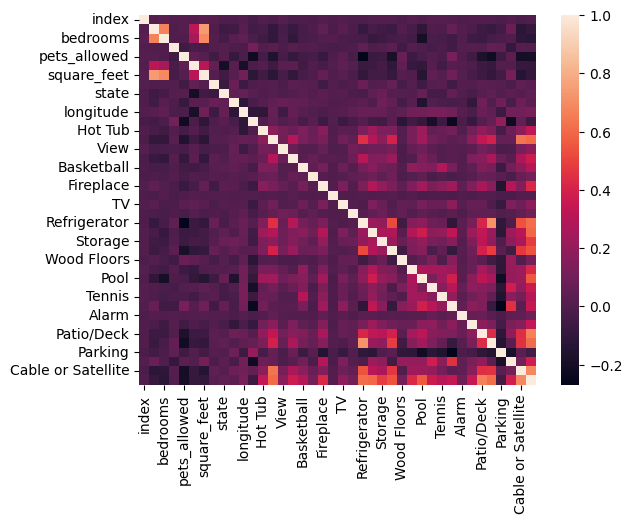

In [273]:
sns.heatmap(corr_matrix)

In [274]:
corr_matrix

,index,bathrooms,bedrooms,has_photo,pets_allowed,price,square_feet,cityname,state,latitude,...,Tennis,Gym,Alarm,Gated,Patio/Deck,Dishwasher,Parking,Washer Dryer,Cable or Satellite,sum_of_items
index,1.000000,0.012059,0.029671,0.003844,0.017054,0.007815,0.027701,0.013291,-0.010800,-0.007555,...,0.017380,0.003137,-0.007465,-0.002983,-0.004336,-0.002657,-0.011900,0.008167,-0.018392,-0.005380
bathrooms,0.012059,1.000000,0.669580,-0.005751,0.011199,0.319131,0.740860,-0.005403,-0.058401,-0.052278,...,-0.006619,0.063510,0.007999,-0.015909,-0.068207,-0.076208,-0.041899,0.077106,-0.121300,-0.092798
bedrooms,0.029671,0.669580,1.000000,-0.002965,-0.002353,0.253346,0.688695,-0.001001,-0.038193,0.024378,...,-0.034897,-0.047193,-0.002480,-0.056547,-0.069463,-0.032494,-0.012977,-0.001525,-0.113812,-0.127873
has_photo,0.003844,-0.005751,-0.002965,1.000000,-0.057620,-0.021476,-0.025998,-0.000631,0.009334,-0.008930,...,-0.013310,-0.053175,0.006742,0.014204,0.002898,0.058197,0.040496,-0.092845,0.015380,0.004325
pets_allowed,0.017054,0.011199,-0.002353,-0.057620,1.000000,0.047488,0.011520,-0.050001,0.015198,-0.082789,...,-0.014677,0.114881,-0.003219,-0.047925,-0.173149,-0.212263,-0.057851,0.034552,-0.196412,-0.191927
price,0.007815,0.319131,0.253346,-0.021476,0.047488,1.000000,0.313915,0.050853,-0.199456,0.021918,...,-0.041514,0.015205,0.000388,-0.010386,-0.070452,-0.083179,0.003073,0.001722,-0.085096,-0.091003
square_feet,0.027701,0.740860,0.688695,-0.025998,0.011520,0.313915,1.000000,0.012774,-0.047640,0.025600,...,0.008952,0.085482,0.008921,-0.030753,-0.066937,-0.097862,-0.042362,0.112523,-0.141018,-0.097821
cityname,0.013291,-0.005403,-0.001001,-0.000631,-0.050001,0.050853,0.012774,1.000000,-0.071202,0.069995,...,0.022782,-0.045839,0.005490,0.003123,0.032547,0.023472,0.014382,-0.014284,0.040932,0.019655
state,-0.010800,-0.058401,-0.038193,0.009334,0.015198,-0.199456,-0.047640,-0.071202,1.000000,0.049725,...,-0.035946,0.053355,0.002537,-0.025680,0.011202,0.040170,0.002506,0.037441,0.016265,0.041540
latitude,-0.007555,-0.052278,0.024378,-0.008930,-0.082789,0.021918,0.025600,0.069995,0.049725,1.000000,...,-0.017546,-0.024342,-0.012389,-0.098834,0.085320,-0.000722,0.092793,-0.025727,0.082468,0.036711


In [275]:
corr_matrix['price'].sort_values(ascending=False)

price                 1.000000
bathrooms             0.319131
square_feet           0.313915
bedrooms              0.253346
cityname              0.050853
pets_allowed          0.047488
Wood Floors           0.044175
TV                    0.039588
Elevator              0.038181
View                  0.025202
latitude              0.021918
AC                    0.017866
Gym                   0.015205
Doorman               0.011300
index                 0.007815
Luxury                0.006366
Hot Tub               0.004991
Parking               0.003073
Washer Dryer          0.001722
Alarm                 0.000388
Golf                 -0.001363
Gated                -0.010386
source               -0.012024
has_photo            -0.021476
Fireplace            -0.027334
Storage              -0.040152
Tennis               -0.041514
Basketball           -0.048936
Internet Access      -0.056494
Clubhouse            -0.067481
Patio/Deck           -0.070452
Refrigerator         -0.073015
Dishwash

### **Feature Extraction**

In [276]:
FeatureExtraction_data=correlation_data.copy()

In [277]:
top_columns=[]

In [278]:
top_columns+=corr_matrix[corr_matrix['price'] >= 0.2]['price'].index.tolist()

In [279]:
top_columns+=corr_matrix[corr_matrix['price'] <= 0.08]['price'].index.tolist()

In [280]:
top_columns

['bathrooms',
 'bedrooms',
 'price',
 'square_feet',
 'index',
 'has_photo',
 'pets_allowed',
 'cityname',
 'state',
 'latitude',
 'longitude',
 'source',
 'Hot Tub',
 'Internet Access',
 'View',
 'Elevator',
 'Basketball',
 'Golf',
 'Fireplace',
 'Luxury',
 'TV',
 'Doorman',
 'Refrigerator',
 'Clubhouse',
 'Storage',
 'Garbage Disposal',
 'Wood Floors',
 'Playground',
 'Pool',
 'AC',
 'Tennis',
 'Gym',
 'Alarm',
 'Gated',
 'Patio/Deck',
 'Dishwasher',
 'Parking',
 'Washer Dryer',
 'Cable or Satellite',
 'sum_of_items']

In [281]:
FeatureExtraction_data=FeatureExtraction_data[top_columns]

In [282]:
FeatureExtraction_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8835 entries, 0 to 8897
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bathrooms           8835 non-null   int32  
 1   bedrooms            8835 non-null   int32  
 2   price               8835 non-null   int64  
 3   square_feet         8835 non-null   float64
 4   index               8835 non-null   int64  
 5   has_photo           8835 non-null   int8   
 6   pets_allowed        8835 non-null   int8   
 7   cityname            8835 non-null   int16  
 8   state               8835 non-null   int8   
 9   latitude            8835 non-null   float64
 10  longitude           8835 non-null   float64
 11  source              8835 non-null   int8   
 12  Hot Tub             8835 non-null   int32  
 13  Internet Access     8835 non-null   int32  
 14  View                8835 non-null   int32  
 15  Elevator            8835 non-null   int32  
 16  Basketball 

### **Models**

#### **LinearRegression**

In [313]:
models_data = FeatureExtraction_data.copy()

In [314]:
X = models_data.drop(columns=["price"])
Y = models_data['price'] 

In [315]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1,shuffle=True,random_state=120)

In [316]:
reg = LinearRegression().fit(X_train, y_train)

In [317]:
y_predict=reg.predict(X_test)

In [318]:
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_predict))
print('accuracy',r2_score(y_test,y_predict))

Mean squared error: 472555.66
accuracy 0.3102488551077144


#### **PolynomialFeatures**

In [319]:
polynomialFeatures_data= FeatureExtraction_data.copy()

In [320]:
x = polynomialFeatures_data.drop(columns=["price"])
y = polynomialFeatures_data['price'] 

In [321]:
degree = 3

In [322]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.30,shuffle=True,random_state=120)

In [323]:
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_train)

In [ ]:
model = LinearRegression().fit(X_poly, y_train)

In [ ]:
X_test_poly = poly_features.transform(X_test)
y_test_pred = model.predict(X_test_poly)

In [ ]:
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_test_pred))
print('accuracy',r2_score(y_test,y_test_pred))

In [308]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Define features (X) and target variable (y)
X = FeatureExtraction_data.drop(columns=['price'])
y = FeatureExtraction_data['price']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=120)

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)


Mean Squared Error: 507857.2760495861
Root Mean Squared Error: 712.641056949139
R-squared: 0.265437992169832


In [310]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Define features (X) and target variable (y)
X = FeatureExtraction_data.drop(columns=['price'])
y = FeatureExtraction_data['price']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=120)

# Initialize and train the Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)


Mean Squared Error: 1513884.6905696657
Root Mean Squared Error: 1230.4002156085903
R-squared: 0.27644922847329345


In [312]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Define features (X) and target variable (y)
X = FeatureExtraction_data.drop(columns=['price'])
y = FeatureExtraction_data['price']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Gradient Boosting Regressor model
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)


Mean Squared Error: 1608058.1782105584
Root Mean Squared Error: 1268.0923382035546
R-squared: 0.23143965801896238
